<img src="https://ucfai.org/core/fa19/2019-11-13-deep-rl/deep-rl/banner.png">

<div class="col-12">
    <span class="btn btn-success btn-block">
        Meeting in-person? Have you signed in?
    </span>
</div>

<div class="col-12">
    <h1> Learning by Doing, This Time With Neural Networks </h1>
    <hr>
</div>

<div style="line-height: 2em;">
    <p>by: 
        <strong> Alec Kerrigan</strong>
        (<a href="https://github.com/ahkerrigan">@ahkerrigan</a>)
     on 2019-11-13</p>
</div>

**What does it formally mean for an agent to explore?**

**Why does an agent need to explore?**

**What are some ways we can allow for exploration?**

**What exactly is the limitation for using a traditional table for reinforcement learning for something like Doom?**

**If you could only replace state space or action space with a nueral network, which would make more sense to replace?**

Let's start with imports


In [0]:
import gym
import numpy as np 
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

Next, we will write a function that can take some batch of data and return a one-hot encoded tensor. One-hot that instead of the integer representing some Nth option, we create a vector of 0s equal to the number of options, and the Nth entry is a 1.

For example, instead of inputting "5" into the network to represent state #5 out of 16 possible states, I input the vector [0, 0, 0, 0, 1, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
def one_hot(ids, nb_digits):
    """
    ids: (list, ndarray) shape:[batch_size]
    """
    if not isinstance(ids, (list, np.ndarray)):
        raise ValueError("ids must be 1-D list or array")
    batch_size = len(ids)
    ids = torch.LongTensor(ids).view(batch_size, 1)
    out_tensor = Variable(torch.FloatTensor(batch_size, nb_digits))
    out_tensor.data.zero_()
    out_tensor.data.scatter_(dim=1, index=ids, value=1.)
    return out_tensor

Next, just for simplicity, we are going to write a funtion that will uniformly set the weights of any Neural Network layer to a uniform value. We do this because you can imagine that when trying to learn something through trial and error, you don't want to start with any assumptions.

Note: This is simply a possible intuition of why starting with uniform weights is the better option. There is no proof that it is in fact better, experiments have simply shown it leads to better results.

In [0]:
def uniform_linear_layer(linear_layer):
    linear_layer.weight.data.uniform_()
    linear_layer.bias.data.fill_(-0.02)

Now, let's create the frozen lake enviroment. As mentioned in the slides, frozen lake is simply a NxN grid in which an agent wants to go from the top left square to the bottom right square without falling in any holes. Occasionally, wind will cause you to move in random directions.


In [0]:
lake = gym.make('FrozenLake-v0')

We can go ahead and see what this enviroment looks like 

In [5]:
lake.reset()
lake.render()


SFFF
FHFH
FFFH
HFFG



Let's take a step and see what it looks like. 

0 - Left

1- Down

2 - Right

3 - Up

**Note - If you (or even I) end up somewhere different than where it says we should be, it's because this enviroment is stochastic, meaning that it occasionally randomly places you somehwere you didn't want to go. This forces the model to deal with randomness**

**Why might stochastic be better than deterministic when training agents?**


In [6]:
s1, r, d, _ = lake.step(2)
lake.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


As you can see, we died, so we went back to where we started. We can show this by looking at the done value

In [7]:
s1, r, d, _ = lake.step(1)
lake.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


As you can see, we died, so we went back to where we started. We can show this by looking at the done value

In [8]:
print(r)
print(d)

0.0
False


For this enviroment, the only time a reward other than 0 is recieved is when you complete the goal, in which you recieve one. We are going to reset regardless of whether the randomness put us where we wanted to go or not. Now, let's build our agent.

In [0]:
class Agent(nn.Module):
  
    """
    Observation Space - How big is the state that the agent needs to observe?
    In this case, the only thing that changes about the lake is the position of the agent.
    Therefore, the observation space is 1
    
    Action Space - Similar to the O-Space, we can move up, down, left, and right 
    Because we need to measure the Q-value of every action, the action space in this 
    case will be 4
    """
    def __init__(self, observation_space_size, action_space_size):
        super(Agent, self).__init__()
        self.observation_space_size = observation_space_size
        self.hidden_size = observation_space_size
        
        # What is the difference between observation and state space?
         
        """
        Let's build the nueral network. In RL, you'll find that large networks 
        are largely unessesary. Oftentimes, you can get away with just 1 or 2 hidden layers
        The reason should be intuitive. What makes something a cat or a dog has many, many variables
        But "wich direction should I walk on a 2D grid" has a lot fewer.
        
        As you can see, the output layer is our action space size. This will be a table
        of our possible actions, each with a q-value
        """

        ## Create a simple 3 layer network using the observation space size as the input
        ## And the action space size as the output

        ### BEGIN SOLUTION
        self.l1 = nn.Linear(in_features=observation_space_size, out_features=self.hidden_size)
        self.l2 = nn.Linear(in_features=self.hidden_size, out_features=action_space_size)
        uniform_linear_layer(self.l1)
        uniform_linear_layer(self.l2)
        ### END SOLUTION
        
        # Why might a nueral network for deep RL be relatively smaller than what you might expect in something like image classification
    
    # Forward feed of our network
    def forward(self, state):
        obs_emb = one_hot([int(state)], self.observation_space_size)
        out1 = F.sigmoid(self.l1(obs_emb))
        return self.l2(out1).view((-1)) # 1 x ACTION_SPACE_SIZE == 1 x 4  =>  4

Now, let's write the trainer that will actually train the agent to navigate the lake.

For this cell, everything inside of train has been jumbled and switched around. Carefully review the steps to the deep-rl process and rearrange them in the correct order.

In [0]:
class Trainer:
    def __init__(self):
        self.agent = Agent(lake.observation_space.n, lake.action_space.n)
        self.optimizer = optim.Adam(params=self.agent.parameters())
        self.success = []
        self.jList = []
        self.running_success = []
    
    def train(self, epoch):
      
      # Let's start by resetting our enviroment
      # We don't want to just wander back and forth forever when the simulation starts
      # Therefore, we use a j value that stops our agent from taking more than 200 
      # actions in a simulation
        for i in range(epoch):
            s = lake.reset()
            j = 0

            """
            # Rearrange these in the correct order
                self.optimizer.zero_grad()
                s = s1
                target_q = r + 0.99 * torch.max(self.agent(s1).detach()) 
                self.optimizer.step()
                if d == True: break
                a = self.choose_action(s)
                j += 1
                loss = F.smooth_l1_loss(self.agent(s)[a], target_q)
                s1, r, d, _ = lake.step(a)
                loss.backward()
                if d == True and r == 0: r = -1
            """
            while j < 200:
                
                ### BEGIN SOLUTION
                # perform chosen action
                a = self.choose_action(s)
                # Every action gives us back the new state (s1), the reward, whether we are done, and some metadata that isn't important here

                s1, r, d, _ = lake.step(a)
                if d == True and r == 0: r = -1
                
                # calculate target and loss`
                # Now, we forward feed the NEW STATE, and find the MAX Q-value that the network thinks we acan get in the future
                # 0.99 here is our gamma. Usually, this should be a variable, but lets not worry about it right now
                # Does this seem strange? Aren't we training the network by observing what the network itself believes is true?
                # Kind of, but in the end the Bellman equation is recursive, so this is our only way of getting that info
                target_q = r + 0.99 * torch.max(self.agent(s1).detach()) # detach from the computing flow
                loss = F.smooth_l1_loss(self.agent(s)[a], target_q)
                
                # update model to optimize Q
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # update state
                s = s1
                j += 1
                if d == True: break
                ### END SOLUTION
            # append results onto report lists
            if d == True and r > 0:
                self.success.append(1)
            else:
                self.success.append(0)
            self.jList.append(j)
            if i % 100 == 0:
              print("last 100 epoches success rate: " + str(sum(self.success[-100:])) + "%")
              self.running_success.append(sum(self.success[-100:]))

    def choose_action(self, s):
      
      # 0.1 is our epsilon
      # Normally, we want some fancy way to degrade this (over time, we should be taking fewer random actions)
      # We will cover this a little more, but for this really, really simple example, we can just use a set epsilon
        if (np.random.rand(1) < 0.1): 
            return lake.action_space.sample()
      # Now, if we don't want to act randomly, we are going to feed forward the network
      # Then, we take the action that has the highest Q-value (max index)
        else:
            agent_out = self.agent(s).detach()
            _, max_index = torch.max(agent_out, 0)
            return int(max_index.data.numpy())

In [48]:
t = Trainer()
t.train(5000)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


last 100 epoches success rate: 0%
last 100 epoches success rate: 0%
last 100 epoches success rate: 1%
last 100 epoches success rate: 1%
last 100 epoches success rate: 5%
last 100 epoches success rate: 14%
last 100 epoches success rate: 18%
last 100 epoches success rate: 15%
last 100 epoches success rate: 23%
last 100 epoches success rate: 7%
last 100 epoches success rate: 12%
last 100 epoches success rate: 25%
last 100 epoches success rate: 25%
last 100 epoches success rate: 35%
last 100 epoches success rate: 36%
last 100 epoches success rate: 41%
last 100 epoches success rate: 39%
last 100 epoches success rate: 40%
last 100 epoches success rate: 40%
last 100 epoches success rate: 35%
last 100 epoches success rate: 45%
last 100 epoches success rate: 31%
last 100 epoches success rate: 40%
last 100 epoches success rate: 37%
last 100 epoches success rate: 41%
last 100 epoches success rate: 44%
last 100 epoches success rate: 28%
last 100 epoches success rate: 40%
last 100 epoches success r

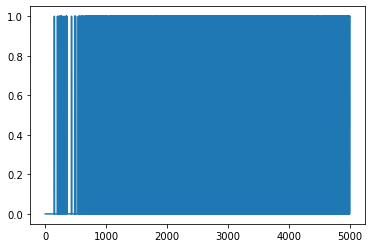

In [41]:
plt.plot(t.success)

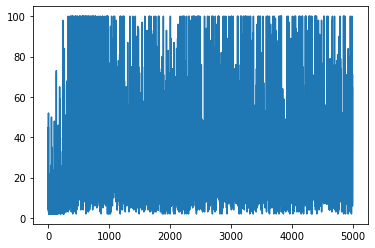

In [42]:
plt.plot(t.jList)

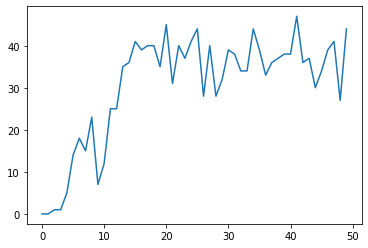

In [49]:
plt.plot(t.running_success)